In [1]:
import numpy as np
import scipy.io as sio
import os
import sys
import torch
from matplotlib import image
import matplotlib.pyplot as plt
import torch.fft as F
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
# import gurobipy
import h5py
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
from utils import *
import time

In [2]:
val_dir = '/mnt/shared_a/data/fastMRI/knee_singlecoil_val.npz'
test_dir = '/mnt/shared_a/data/fastMRI/knee_singlecoil_test.npz'
valdata = np.load(val_dir)['data']
testdata = np.load(test_dir)['data']
print(valdata.shape)
print(testdata.shape)

(1287, 320, 320)
(1300, 320, 320)


# train test split prep

In [ ]:
data_dir1 = '/home/huangz78/data/data_gt.npz'
data1 = np.load(data_dir1)
print('file1',data1.files)
print(data1['imgdata'].shape)
data_dir2 = '/mnt/shared_b/data/fastMRI/singlecoil_train/expanded_gt.npz'
data2 = np.load(data_dir2)
print('file2',data2.files)
print(data2['imgdata'].shape)

# data = np.concatenate((data1['imgdata'],data2['imgdata']),axis=2)
data = np.concatenate((data2['imgdata'],data1['imgdata']),axis=2)
del data1
del data2

In [ ]:
from sklearn.model_selection import train_test_split
imgNum = 199+1014
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=1000)

In [ ]:
traininds = np.arange(0,1014,1)
testinds  = np.arange(1014,199+1014,1)

In [ ]:
# trainimgs = data['imgdata'][:,:,traininds]
# testimgs = data['imgdata'][:,:,testinds]
dtyp = torch.float
Dtyp = torch.cfloat
trainimgs = data[:,:,traininds]
testimgs  = data[:,:,testinds]
train_y = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=Dtyp)
train_yfull = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=Dtyp)
train_x = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=dtyp)
train_xfull = torch.zeros((trainimgs.shape[2],trainimgs.shape[0],trainimgs.shape[1]),dtype=dtyp)

test_y  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=Dtyp)
test_yfull  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=Dtyp)
test_x  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=dtyp)
test_xfull  = torch.zeros((testimgs.shape[2],testimgs.shape[0],testimgs.shape[1]),dtype=dtyp)

#### load an image and make it into correct shape

In [7]:
# filename = 'file1000605.h5'
filename = 'file1000568.h5'
f = h5py.File(filename, 'r')
print(f.keys())

<KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']>


/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


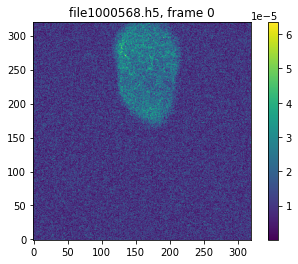

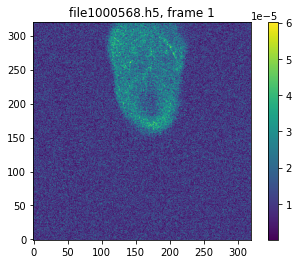

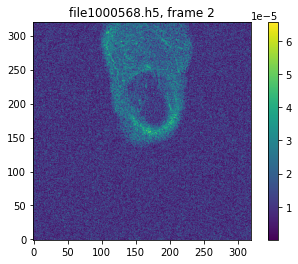

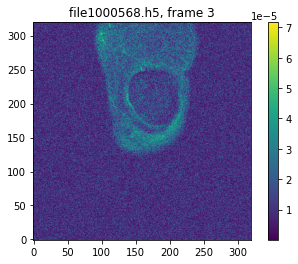

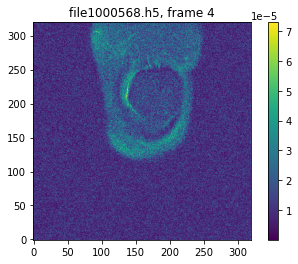

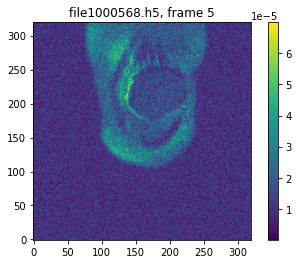

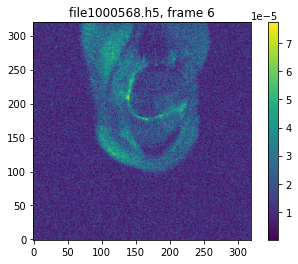

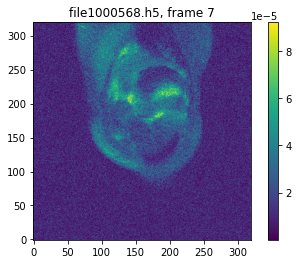

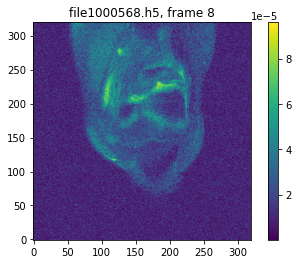

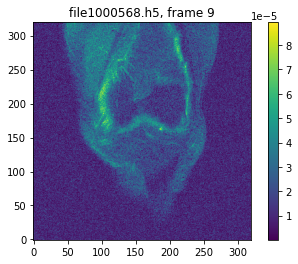

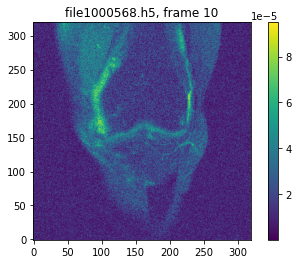

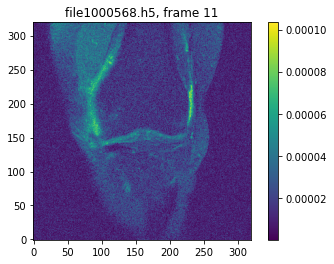

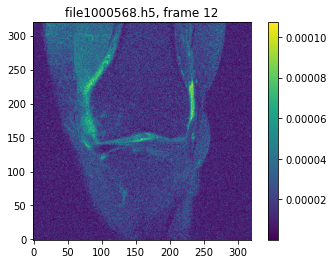

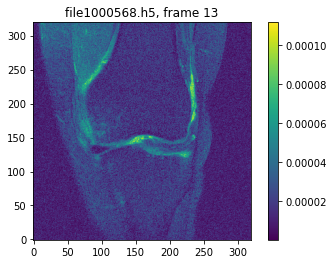

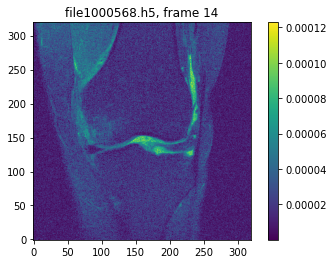

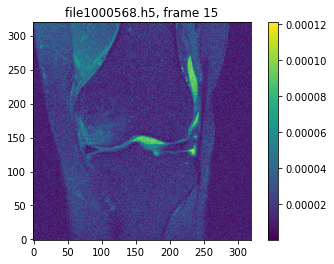

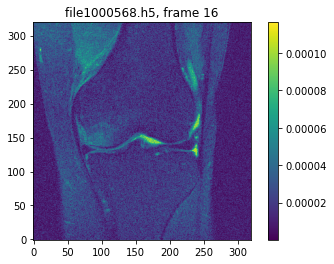

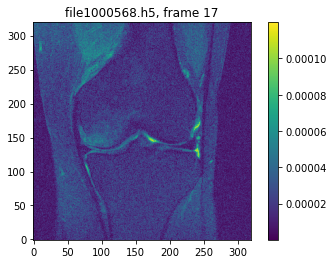

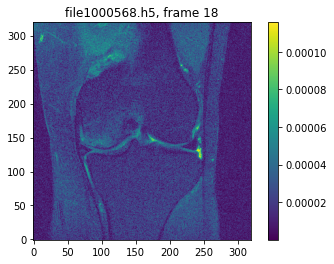

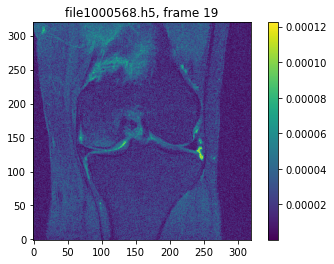

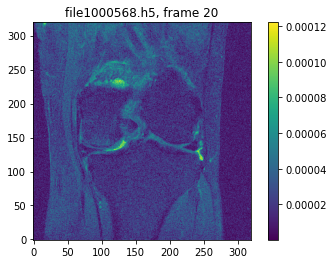

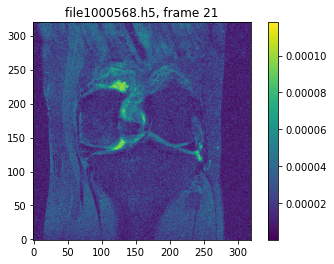

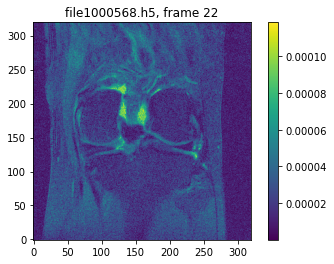

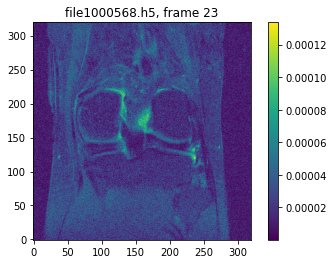

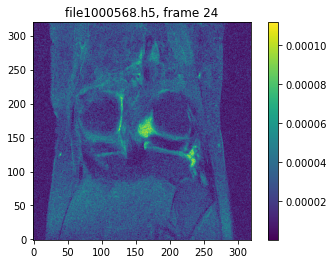

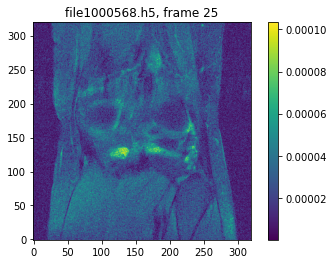

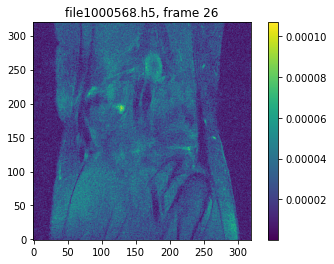

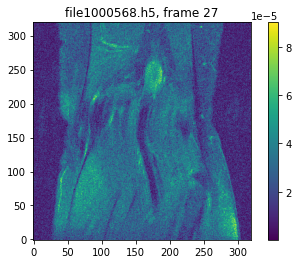

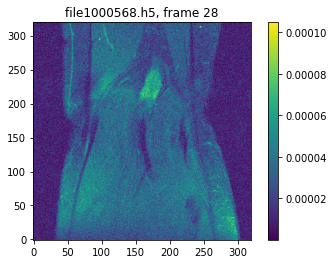

In [8]:
for ind in range(f['reconstruction_esc'].shape[0]):
    plt.imshow(f['reconstruction_esc'].value[ind,:,:],origin='lower')
    plt.title(f'{filename}, frame {ind}')
    plt.colorbar()
    plt.show()
f.close()

In [2]:
# prepare document list with all files end with .h5
fastMRI_path = '/mnt/shared_b/data/fastMRI/singlecoil_train'
# fastMRI_path = '/mnt/shared_b/data/fastMRI/singlecoil_val/'
# fastMRI_path = '/mnt/shared_b/data/fastMRI/singlecoil_test_v2/' # ALL files in this directory is broken!
os.chdir(fastMRI_path)
doculist = list([])
for file in os.listdir(fastMRI_path):
    if (not file.startswith('.')) and (file.endswith('.h5')):
#     if (not file.startswith('.')) and (not file.endswith('.npz')) and (not file.endswith('.txt')):
        doculist.append(file)
print(len(doculist))

973


In [9]:
13*973

12649

In [6]:
for file in doculist:
    try:
        f = h5py.File(file,'r')
        print('filename: ', file, '\t', 'Number of images: ', f['reconstruction_esc'].shape[0])
        f.close()
    except:
        print(file,'failed to be opened')

filename:  file1001206.h5 	 Number of images:  33
filename:  file1000001.h5 	 Number of images:  36
filename:  file1000002.h5 	 Number of images:  38
filename:  file1000003.h5 	 Number of images:  45
filename:  file1000005.h5 	 Number of images:  35
filename:  file1000010.h5 	 Number of images:  36
filename:  file1000012.h5 	 Number of images:  32
filename:  file1000015.h5 	 Number of images:  36
filename:  file1000021.h5 	 Number of images:  35
filename:  file1000023.h5 	 Number of images:  34
filename:  file1000027.h5 	 Number of images:  34
filename:  file1000029.h5 	 Number of images:  33
filename:  file1000032.h5 	 Number of images:  32
filename:  file1000039.h5 	 Number of images:  33
filename:  file1000040.h5 	 Number of images:  38
filename:  file1000043.h5 	 Number of images:  41
filename:  file1000045.h5 	 Number of images:  42
filename:  file1000048.h5 	 Number of images:  38
filename:  file1000053.h5 	 Number of images:  30
filename:  file1000188.h5 	 Number of images:  36


filename:  file1001323.h5 	 Number of images:  32
filename:  file1001327.h5 	 Number of images:  37
filename:  file1001328.h5 	 Number of images:  38
filename:  file1001333.h5 	 Number of images:  38
filename:  file1001334.h5 	 Number of images:  34
filename:  file1001340.h5 	 Number of images:  33
filename:  file1001342.h5 	 Number of images:  33
filename:  file1001348.h5 	 Number of images:  30
filename:  file1001350.h5 	 Number of images:  34
filename:  file1001353.h5 	 Number of images:  30
filename:  file1001445.h5 	 Number of images:  33
filename:  file1001449.h5 	 Number of images:  36
filename:  file1001452.h5 	 Number of images:  33
filename:  file1001455.h5 	 Number of images:  44
filename:  file1001459.h5 	 Number of images:  38
filename:  file1001460.h5 	 Number of images:  38
filename:  file1001465.h5 	 Number of images:  28
filename:  file1001468.h5 	 Number of images:  33
filename:  file1001470.h5 	 Number of images:  37
filename:  file1001474.h5 	 Number of images:  40


filename:  file1002476.h5 	 Number of images:  30
filename:  file1002478.h5 	 Number of images:  38
filename:  file1002479.h5 	 Number of images:  28
filename:  file1002481.h5 	 Number of images:  35
filename:  file1002485.h5 	 Number of images:  34
filename:  file1002491.h5 	 Number of images:  30
filename:  file1002492.h5 	 Number of images:  38
filename:  file1002494.h5 	 Number of images:  33
filename:  file1002495.h5 	 Number of images:  34
filename:  file1002497.h5 	 Number of images:  30
filename:  file1002499.h5 	 Number of images:  36
filename:  file1002500.h5 	 Number of images:  30
filename:  file1002505.h5 	 Number of images:  36
filename:  file1002509.h5 	 Number of images:  34
filename:  file1000418.h5 	 Number of images:  30
filename:  file1000420.h5 	 Number of images:  32
filename:  file1000424.h5 	 Number of images:  36
filename:  file1000425.h5 	 Number of images:  35
filename:  file1000426.h5 	 Number of images:  34
filename:  file1000427.h5 	 Number of images:  34


filename:  file1001677.h5 	 Number of images:  33
filename:  file1001685.h5 	 Number of images:  36
filename:  file1001688.h5 	 Number of images:  36
filename:  file1001690.h5 	 Number of images:  32
filename:  file1001692.h5 	 Number of images:  38
filename:  file1001694.h5 	 Number of images:  35
filename:  file1001695.h5 	 Number of images:  35
filename:  file1001698.h5 	 Number of images:  30
filename:  file1001699.h5 	 Number of images:  31
filename:  file1001701.h5 	 Number of images:  38
filename:  file1001706.h5 	 Number of images:  36
filename:  file1001707.h5 	 Number of images:  35
filename:  file1001708.h5 	 Number of images:  36
filename:  file1001710.h5 	 Number of images:  35
filename:  file1001711.h5 	 Number of images:  36
filename:  file1001713.h5 	 Number of images:  34
filename:  file1001071.h5 	 Number of images:  32
filename:  file1001079.h5 	 Number of images:  33
filename:  file1001082.h5 	 Number of images:  38
filename:  file1001084.h5 	 Number of images:  30


filename:  file1001867.h5 	 Number of images:  33
filename:  file1001870.h5 	 Number of images:  32
filename:  file1001872.h5 	 Number of images:  35
filename:  file1001873.h5 	 Number of images:  38
filename:  file1001875.h5 	 Number of images:  33
filename:  file1001878.h5 	 Number of images:  35
filename:  file1001879.h5 	 Number of images:  38
filename:  file1001883.h5 	 Number of images:  45
filename:  file1001888.h5 	 Number of images:  38
filename:  file1001891.h5 	 Number of images:  34
filename:  file1001892.h5 	 Number of images:  34
filename:  file1001901.h5 	 Number of images:  35
filename:  file1001902.h5 	 Number of images:  36
filename:  file1001905.h5 	 Number of images:  34
filename:  file1001906.h5 	 Number of images:  33
filename:  file1002054.h5 	 Number of images:  35
filename:  file1002055.h5 	 Number of images:  30
filename:  file1002056.h5 	 Number of images:  35
filename:  file1002062.h5 	 Number of images:  32
filename:  file1002063.h5 	 Number of images:  37


In [ ]:
# what volumes should we pick? 'diff' below means the number of volumes we should select
diff = 6
indset = np.random.choice(range(len(doculist)),size=20,replace=False)
for ind in indset:
    try:
        filename = doculist[ind]
        f = h5py.File(filename, 'r')
        total_frames = f['reconstruction_esc'].shape[0]
        print(filename,'number of frames: ', total_frames)
        
        im = torch.tensor(f['reconstruction_esc'][total_frames//2-diff,:,:])
        plt.title(filename+'  slice: '+str(total_frames//2-diff))
        plt.imshow(im,origin='lower')
        plt.colorbar()
        plt.show()
        
        im = torch.tensor(f['reconstruction_esc'][total_frames//2+diff,:,:])
        plt.title(filename+'  slice: '+str(total_frames//2+diff))
        plt.imshow(im,origin='lower')
        plt.colorbar()
        plt.show()
        
        f.close()
    except:
#         doculist.remove(filename)
        print('failed to open the file: ',filename)

In [ ]:
# create training/validation/testing dataset
diff = 6
# doculist = doculist[0:99] # validation
doculist = doculist[99:] # test
imgdata = np.zeros((len(doculist)*(2*diff+1),320,320))
imgind = 0
for filename in doculist:
    f = h5py.File(filename, 'r')    
    fsize = f['reconstruction_esc'].shape[0]
    print(filename, fsize)
    for ind in np.arange(-diff,diff+1,1):
        imgdata[imgind,:,:] = torch.tensor(f['reconstruction_esc'][fsize//2+ind,:,:])
        imgind += 1
print(len(doculist)*(2*diff+1),imgind)

In [ ]:
# save training dataset
# filename = '/mnt/shared_a/data/fastMRI/knee_singlecoil_train.npz'
# filename = '/mnt/shared_a/data/fastMRI/knee_singlecoil_val.npz'
filename = '/mnt/shared_a/data/fastMRI/knee_singlecoil_test.npz'
np.savez(filename,data=imgdata)

In [ ]:
im = torch.tensor(f['reconstruction_rss'][22,:,:])
plt.imshow(im,cmap='gray')
plt.colorbar()
y = F.fftn(im,dim=(0,1),norm='ortho')
f.close()


imgHeg = y.shape[0]
imgWid = y.shape[1]
if len(y.shape)<3:
     y = y.view((y.shape[0],y.shape[1],1)) 
x_star  = im.view(imgHeg,imgWid,-1)

##### load Siddhant's greedy mask

In [ ]:
### load greedy mask provided by Siddhant
file1 = np.load('/mnt/shared_b/gautamsi/mri-sampling/simulation-results/greedy_fastmri_mp50.npz')
file2 = np.load('/mnt/shared_b/gautamsi/mri-sampling/simulation-results/greedy_fastmri_mp100.npz')
file3 = np.load('/mnt/shared_b/gautamsi/mri-sampling/simulation-results/greedy_fastmri_mp150.npz')
file4 = np.load('/mnt/shared_b/gautamsi/mri-sampling/simulation-results/greedy_fastmri_mp198.npz')
file5 = np.load('/mnt/shared_b/gautamsi/mri-sampling/simulation-results/greedy_fastmri_mp199.npz')
mask1 = file1['arr_0']; mask2 = file2['arr_0']; mask3 = file3['arr_0']; mask4 = file4['arr_0']; mask5 = file5['arr_0']
plt.imshow(mask1[:,:,0])

In [ ]:
masks = [mask1,mask2,mask3,mask4,mask5]
mask_label = np.zeros((320,199))
ind = 0
for maskfile in masks:
    masknum = maskfile.shape[2]
    for i in range(masknum):
        mask_label[:,i+ind] = maskfile[0,:,i]
    ind += masknum

np.savez('/home/huangz78/data/data_gt_greedymask.npz',mask=mask_label)

### At what sampling ratio does random sampling overtake low frequency sampling ?
    - Conclusion : 30% base, 10% additional

In [ ]:
# At what sampling ratio does random sampling overtake low frequency sampling ?
# Conclusion : 30% base, 10% additional
# lamda = 5e-7
np.random.seed(0)
roll_flag = True
mps = np.ones((1,imgHeg,imgWid))
# x_recon = np.fft.fftshift(np.real(TotalVariationRecon(ksp, mps, lamda, weights=mask).run()))
# x_recon = np.fft.fftshift(np.real(L1WaveletRecon(ksp, mps, lamda, weights=mask).run()))
# l1wavelet: -9,-8.5; tv: -6.5,-6.3
lamda = 10**(-6.31)

base_r_grid = np.linspace(.25,.35,10)
rand_r = 0.1
error_rand = np.zeros(base_r_grid.size); error_freq = np.zeros(base_r_grid.size)

Rep = 10

ind = 0
for base_r in base_r_grid:
#     base_r = 0.3; 
    total_r   = base_r + rand_r    
    mask_freq,_,_ = mask_naiveRand(imgHeg,fix=imgHeg*total_r,other=0,roll=roll_flag)
    mask_freq = mask_freq.numpy()
    y_freq = np.reshape(np.diag(mask_freq)@yraw,(-1,imgHeg,imgWid)) 
    
    rep = 0
    while rep < Rep:
        mask_rand = mask_prob(img,fix=imgHeg*base_r,other=imgHeg*rand_r,roll=roll_flag,seed=int(time.strftime('%S')))
        y_rand = np.reshape(np.diag(mask_rand)@yraw,(-1,imgHeg,imgWid)) 
        x_recon_rand = np.fft.fftshift( np.real(TotalVariationRecon(y_rand,mps,lamda,show_pbar=False,max_iter=50).run()) )
        error_rand[ind] += np.sqrt( np.sum((x_recon_rand.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
        rep += 1
    error_rand[ind] /= Rep
    
    x_recon_freq = np.fft.fftshift( np.real(TotalVariationRecon(y_freq,mps,lamda,show_pbar=False,max_iter=50).run()) )
    error_freq[ind] = np.sqrt( np.sum((x_recon_freq.flatten()-img.flatten())**2) )/np.sqrt( np.sum( (img.flatten())**2 ))
    # error_rand = np.mean(np.abs(x_recon_rand.flatten()-img.flatten())) 
    # error_freq = np.mean(np.abs(x_recon_freq.flatten()-img.flatten())) 

    print('rand.     mask recon. error = ' , error_rand[ind])
    print('low.freq. mask recon. error = ' , error_freq[ind])
    ind += 1

plt.figure()
plt.plot(base_r_grid,error_rand,label='rand')
plt.plot(base_r_grid,error_freq,label='freq')
plt.legend()
plt.show()

### sanity test
  - shepp-logan phantom
  - brain img from class material
  - the following cells are mostly loading imgs into notebook

In [ ]:
fastMRI_path = '/Users/leonardohuang/Desktop/msu_research/code/data/singlecoil_val/'
# sys.path.append(fastMRI_path)
imgHeg   = 320
imgWid   = 320
DType    = torch.cfloat

os.chdir(fastMRI_path)
filename = 'file1001557.h5'
f = h5py.File(filename, 'r')
print(f.keys())

im = torch.tensor(f['reconstruction_rss'][22,:,:])
plt.imshow(im,cmap='gray')
plt.colorbar()
y = F.fftn(im,dim=(0,1),norm='ortho')
f.close()

In [ ]:
# shepp-logan phantom image loading
im = image.imread('/Users/leonardohuang/Desktop/msu_research/code/data/phantom.gif')
im = torch.tensor(im[:,:,0]).to(torch.float)
imgHeg = im.shape[0]
imgWid = im.shape[1]
y = F.fftn(im,dim=(0,1),norm='ortho')
DType  = torch.cfloat
plt.clf()
plt.imshow(im)
plt.colorbar()

In [ ]:
def rescale_sp(x):
    maxval = np.max(np.abs(x))
    minval = np.min(np.abs(x))
    K = 255./(maxval-minval)
    B = - (minval*255.)/(maxval-minval)
    x = K*x+B
    return x

### prepare useful FastMRI dataset

In [ ]:
imgdata = np.load('/home/huangz78/data/imgdata.npz')
data = imgdata['imgdata']

In [ ]:
base = .3
addi = .1
imgHeg = 320
labels = np.zeros((199,int(imgHeg*(1-base))))
suby   = np.zeros((199,int(imgHeg*base),320,2))
ifftimgs  = np.zeros((199,320,320))

coreInds = np.arange(int(imgHeg/2)-int(imgHeg*base/2), int(imgHeg/2)+int(imgHeg*base/2))
mask_low,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*base),other=0,roll=True)
mask_low = mask_low.numpy()

np.random.seed(2021)
for ind in range(199):
    img = data[:,:,ind]
    fullmask = mask_prob(img,fix=imgHeg*base,other=imgHeg*addi,roll=True)
    labels[ind,:] = fullmask[np.setdiff1d(np.arange(imgHeg),coreInds)] # labels for high freq
    
    yraw = np.fft.fftshift(np.fft.fftn(img,norm='ortho'))
    y = np.diag(mask_low)@yraw # subsampled y
    ifftimgs[ind,:,:] = np.abs(np.fft.ifftn(np.fft.fftshift(y),norm='ortho')) # ifft imgs
    suby[ind,:,:,0] = np.real(y[coreInds,:]) # subsampled y real
    suby[ind,:,:,1] = np.imag(y[coreInds,:]) # subsampled y imag


In [ ]:
filepath = '/home/huangz78/data/datafornn.npz'
np.savez(filepath,labels=labels,sub_y=suby,ifftimgs=ifftimgs)

In [ ]:
img = data[:,:,3]
fullmask = mask_prob(img,fix=imgHeg*base,other=imgHeg*addi,roll=True)
labels[ind,:] = fullmask[np.setdiff1d(np.arange(imgHeg),coreInds)]

mask_low,_,_ = mask_naiveRand(imgHeg,fix=int(imgHeg*base),other=0,roll=True)
mask_low = mask_low.numpy()
yraw = np.fft.fftshift(np.fft.fftn(img,norm='ortho'))
y = np.diag(mask_low)@yraw
xifft = np.abs(np.fft.ifftn(np.fft.fftshift(y),norm='ortho'))

plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title('orig img')
plt.imshow(img)
plt.colorbar()

plt.subplot(312)
plt.title('naive masked y')
plt.imshow(np.log(np.abs(y)))
plt.colorbar()

plt.subplot(313)
plt.title('ifft img')
plt.imshow(xifft)
plt.colorbar()

plt.show()

kplot(fullmask)

### manually select images by printing all images for view

In [ ]:
fastMRI_path = '/Users/leonardohuang/Desktop/msu_research/code/data/singlecoil_val/'
# sys.path.append(fastMRI_path)
imgHeg   = 320
imgWid   = 320
DType    = torch.cfloat

doculist = list([])
for file in os.listdir(fastMRI_path):
    if not file.startswith('.'):
        doculist.append(file)
# docutrain,docutest = train_test_split(doculist,train_size=int(len(doculist)*.8), random_state=1024)
# print('Number of image documents for training: ', len(docutrain))
# print('Number of image documents for testing : ', len(docutest) )

In [ ]:
data = {}
mainInd = int(26)
fileind = 0
for filename in doculist:
    print("image {} out of {}".format(fileind+1,len(doculist)))
    f  = h5py.File(filename,'r')    
    fileNum = f['reconstruction_rss'].shape[0]
    if mainInd < fileNum:
        plt.clf()
        plt.imshow(f['reconstruction_rss'][mainInd,:,:])
        plt.title('{0}: slice {1}'.format(filename,mainInd))
        plt.colorbar()
        plt.show()
        indicator = input()
        goodind = mainInd
        if int(indicator) != 1:
            for ind in range(18,min(32,fileNum),1):
                plt.clf()
                plt.imshow(f['reconstruction_rss'][ind,:,:])
                plt.title('{0}: slice {1}'.format(filename,ind))
                plt.colorbar()
                plt.show()
            goodind = input()
        data[filename] = int(goodind)
    else:
        print(filename," fails to load ", mainInd, " slice!!!")
    f.close()
    fileind += 1

#     for pic in range(fileNum):   

In [ ]:
database = data.copy()

In [ ]:
f = h5py.File(list(database.keys())[51],'r')
for ind in range(f['reconstruction_rss'].shape[0]):
                plt.clf()
                plt.imshow(f['reconstruction_rss'][ind,:,:])
                plt.title('{0}: slice {1}'.format(filename,ind))
                plt.colorbar()
                plt.show()

f.close()

In [ ]:
f = open("dict.txt","w")
f.write( str(database) )
f.close()

In [ ]:
np.savez('imgdata',imgdata=imgdata)